# Modelo de Minería de Datos

## 1. Introducción

### Descripción del proyecto:

Este proyecto trata de construir un modelo de minería de datos descriptivo que permita a The Quiz Challenge identificar qué tipo de videos deben producir para maximizar vistas y suscriptores.

### Tipo de Tarea Elegida:

La tarea elegida fue la de Clustering porque vimos bien la manera en que con esta técnica podiamos agrupar videos similares basados en características relevantes para el crecimiento del canal.

## 2. Objetivo del Modelo

### Objetivo General

El objetivo general de este modelo es identificar patrones y tendencias en el contenido de videos que puedan ayudar al canal The Quiz Challenge a seleccionar temáticas para los videos con el fin de maximizar las vistas y la entrada de suscriptores. Esto se logrará mediante la técnica de Clustering, que agrupará videos similares basados en características relevantes.

## 3. Datos Utilizados

### Descripción del Conjunto de Datos:

- Fuente: video_data_for_clustering.csv

- Características Clave: vistas, tiempo de reproducción (horas), suscriptores, duración promedio de vistas (segundos), impresiones, tasa de clics.

### Integración de Fuentes Adicionales:

Se considerará la integración de datos demográficos o tendencias actuales en Youtube para enriquecer el análisis, agregamos columnas como:

- Categoría: para clasificar los videos por categorías similares.

- is_short: para identificar los videos que son shorts o que son videos normales.

- has_emojis y has_hashtags: para identificar si los videos tienen emojis o hashtags en el título.

- country_with_max_views: para saber cuál país tiene el mayor numero de vistas.

- total_subscriptions y total_subscription_loss: para ver como va cambiando el flujo de suscripciones a medida que suben videos.

## 4. Preprocesamiento de Datos

### Librerías Importadas:

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import silhouette_score

### Carga y Transformación de Datos:

In [ ]:
data = pd.read_csv('video_data_for_clustering.csv')
data['Duración promedio de vistas'] = pd.to_timedelta(data['Duración promedio de vistas']).dt.total_seconds()

### Seleccion de Características:

In [ ]:
numerical_cols = ['Vistas', 'Tiempo de reproducción (horas)', 'Suscriptores', 
                 'Duración promedio de vistas', 'Impresiones', 
                 'Tasa de clics de las impresiones (%)', 'views_until_next_video', 
                 'total_subscriptions', 'total_subscription_loss']

categorical_cols = ['Categoría', 'is_short', 'has_emojis', 'has_hashtags', 
                   'country_with_max_views']

In [ ]:
le = LabelEncoder()
features = data[numerical_cols].copy()

In [ ]:
for col in categorical_cols:
    if col in data.columns:
        features[col] = le.fit_transform(data[col].astype(str))

## 5. Escalado y Reducción de Dimensionalidad

### Normalización:

In [ ]:
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

### Reducción con PCA:

In [ ]:
pca_initial = PCA()
features_pca_initial = pca_initial.fit_transform(features_scaled)
cumsum = np.cumsum(pca_initial.explained_variance_ratio_)
n_components = np.argmax(cumsum > 0.4) + 1

In [ ]:
print(f"Número de componentes seleccionados: {n_components}")

In [ ]:
pca = PCA(n_components=n_components)
features_pca = pca.fit_transform(features_scaled)

# 6. Construcción del Modelo

### Aplicación del Algoritmo K-Means:

In [ ]:
inertia = []
silhouette_scores = []
K = range(2, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(features_pca)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(features_pca, kmeans.labels_))

# 7. Evaluación del Modelo:

### Métricas Utilizadas:

- Inercia: Mide la compactación dentro de los clusters.

- Coeficiente Silhouette: Evalúa dla separación entre clusters.

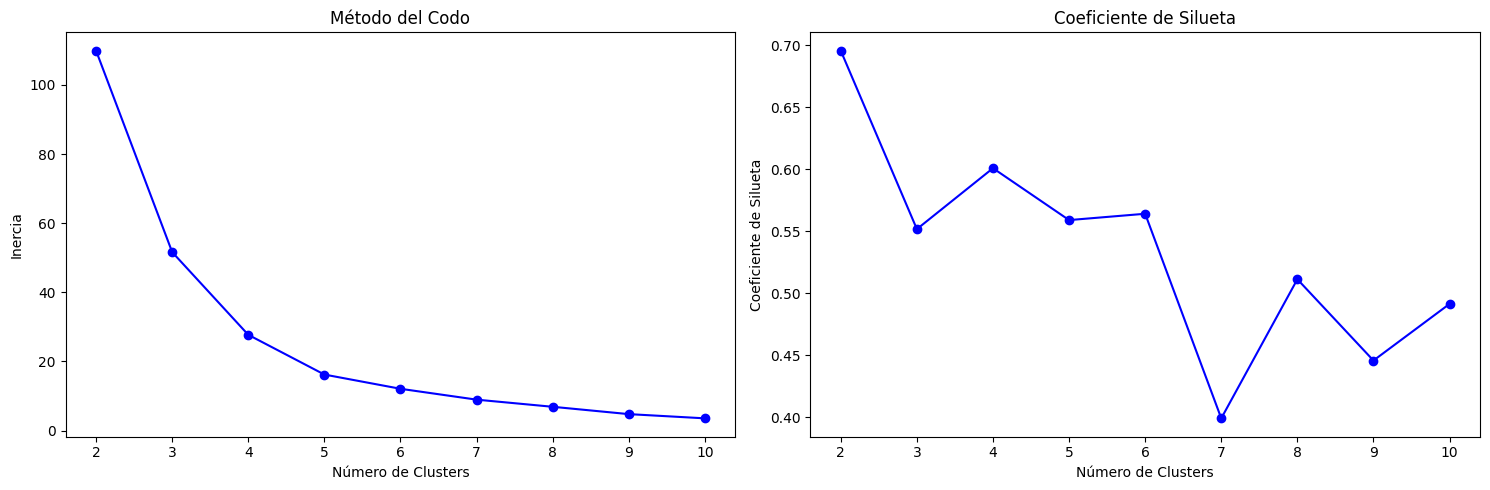

In [11]:
# Gráfico del método del codo
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(K, inertia, 'bo-')
plt.xlabel('Número de Clusters')
plt.ylabel('Inercia')
plt.title('Método del Codo')

# Gráfico del coeficiente de silueta
plt.subplot(1, 2, 2)
plt.plot(K, silhouette_scores, 'bo-')
plt.xlabel('Número de Clusters')
plt.ylabel('Coeficiente de Silueta')
plt.title('Coeficiente de Silueta')

plt.tight_layout()
plt.show()

In [12]:
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(features_pca)

In [13]:
data['Cluster'] = cluster_labels

for cluster in range(optimal_k):
    print(f"\n\nCluster {cluster}:")
    print("=" * 80)
    cluster_data = data[data['Cluster'] == cluster].sort_values(by='Vistas', ascending=False)
    
    # Imprimir resumen del cluster
    print(f"\nNúmero de videos en el cluster: {len(cluster_data)}")
    print("\nPromedios del cluster:")
    print(f"Vistas promedio: {cluster_data['Vistas'].mean():,.2f}")
    print(f"Tiempo de reproducción promedio: {cluster_data['Tiempo de reproducción (horas)'].mean():.2f} horas")
    print(f"Tasa de clics promedio: {cluster_data['Tasa de clics de las impresiones (%)'].mean():.2f}%")
    
    if 'is_short' in data.columns:
        print(f"Porcentaje de Shorts: {(cluster_data['is_short'] == True).mean() * 100:.2f}%")
    if 'has_emojis' in data.columns:
        print(f"Porcentaje con emojis: {(cluster_data['has_emojis'] == True).mean() * 100:.2f}%")
    if 'has_hashtags' in data.columns:
        print(f"Porcentaje con hashtags: {(cluster_data['has_hashtags'] == True).mean() * 100:.2f}%")
    
    print("\nTop 5 videos en este cluster:")
    print("-" * 80)
    for idx, row in cluster_data.head().iterrows():
        print(f"Título: {row['Título del video']}")
        print(f"Vistas: {row['Vistas']:,.0f}")
        print(f"Tiempo de reproducción: {row['Tiempo de reproducción (horas)']:.2f} horas")
        print(f"Tasa de clics: {row['Tasa de clics de las impresiones (%)']}%")
        if 'Categoría' in row:
            print(f"Categoría: {row['Categoría']}")
        if 'country_with_max_views' in row:
            print(f"País con más vistas: {row['country_with_max_views']}")
        print("-" * 80)




Cluster 0:

Número de videos en el cluster: 3

Promedios del cluster:
Vistas promedio: 2,338.00
Tiempo de reproducción promedio: 63.87 horas
Tasa de clics promedio: 4.55%
Porcentaje de Shorts: 0.00%
Porcentaje con emojis: 0.00%
Porcentaje con hashtags: 0.00%

Top 5 videos en este cluster:
--------------------------------------------------------------------------------
Título: Harry Potter EXPERTS Only! Tricky Questions Ahead!
Vistas: 3,246
Tiempo de reproducción: 119.66 horas
Tasa de clics: 3.95%
Categoría: Películas y Cultura Pop
País con más vistas: US
--------------------------------------------------------------------------------
Título: The Most Difficult Flag Quiz Ever (Can You Get Them All?)
Vistas: 2,252
Tiempo de reproducción: 27.72 horas
Tasa de clics: 5.95%
Categoría: Geografía y Banderas
País con más vistas: US
--------------------------------------------------------------------------------
Título: Harry Potter | Facts Quiz
Vistas: 1,516
Tiempo de reproducción: 44.24 hora

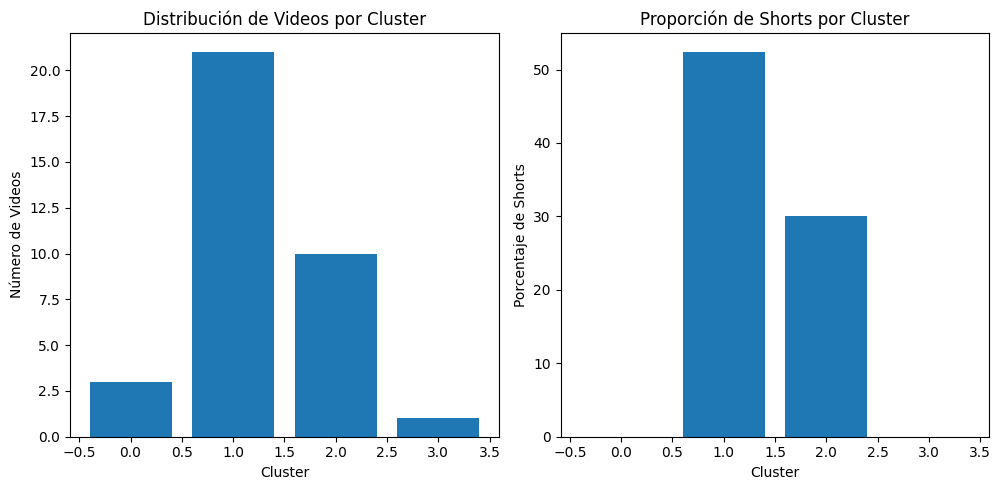

In [14]:
# Visualización de la distribución de videos por cluster
plt.figure(figsize=(15, 5))

# Gráfico 1: Distribución de videos por cluster
plt.subplot(1, 3, 1)
cluster_sizes = data['Cluster'].value_counts().sort_index()
plt.bar(cluster_sizes.index, cluster_sizes.values)
plt.title('Distribución de Videos por Cluster')
plt.xlabel('Cluster')
plt.ylabel('Número de Videos')

# Gráfico 2: Proporción de Shorts por cluster (si existe)
if 'is_short' in data.columns:
    plt.subplot(1, 3, 2)
    shorts_prop = data.groupby('Cluster')['is_short'].mean()
    plt.bar(shorts_prop.index, shorts_prop.values * 100)
    plt.title('Proporción de Shorts por Cluster')
    plt.xlabel('Cluster')
    plt.ylabel('Porcentaje de Shorts')

plt.tight_layout()
plt.show()

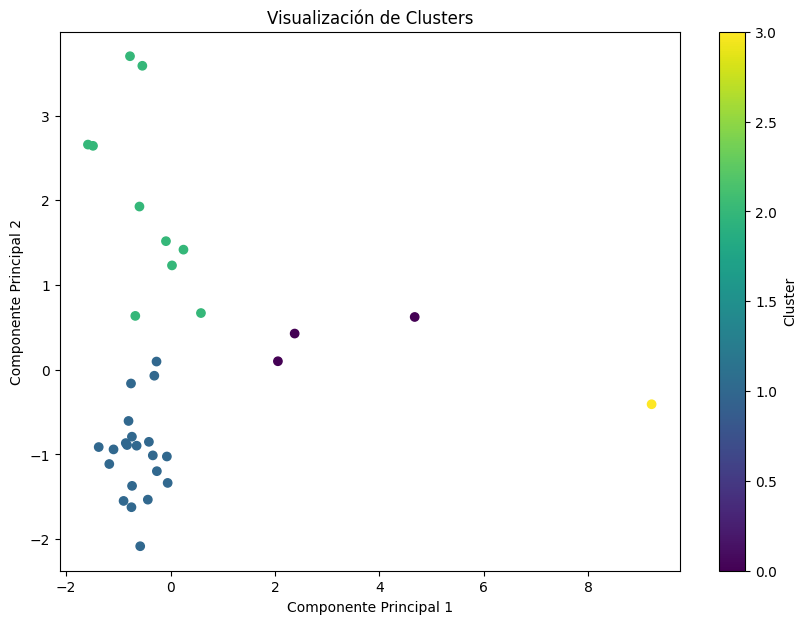

In [15]:
# Gráfico de dispersión de los clusters
plt.figure(figsize=(10, 7))
plt.scatter(features_pca[:, 0], features_pca[:, 1], c=cluster_labels, cmap='viridis', marker='o')
plt.title('Visualización de Clusters')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.colorbar(label='Cluster')
plt.show()

In [16]:
# Mostrar varianza explicada
print("\nVarianza explicada por cada componente:")
for i, var in enumerate(pca.explained_variance_ratio_):
    print(f"Componente {i+1}: {var:.4f} ({var*100:.2f}%)")
print(f"Varianza total explicada: {sum(pca.explained_variance_ratio_)*100:.2f}%")


Varianza explicada por cada componente:
Componente 1: 0.2746 (27.46%)
Componente 2: 0.1585 (15.85%)
Varianza total explicada: 43.31%


In [17]:
# Análisis adicional de características categóricas por cluster
if 'Categoría' in data.columns:
    print("\nDistribución de categorías por cluster:")
    for cluster in range(optimal_k):
        print(f"\nCluster {cluster}:")
        print(data[data['Cluster'] == cluster]['Categoría'].value_counts().head())


Distribución de categorías por cluster:

Cluster 0:
Categoría
Películas y Cultura Pop    2
Geografía y Banderas       1
Name: count, dtype: int64

Cluster 1:
Categoría
Deportes y Eventos Internacionales    8
Ciencia y Naturaleza                  6
Geografía y Banderas                  3
Historia y Sociedad                   1
Películas y Cultura Pop               1
Name: count, dtype: int64

Cluster 2:
Categoría
Juegos Would You Rather      4
Películas y Cultura Pop      3
Ciencia y Naturaleza         2
Especiales y Festividades    1
Name: count, dtype: int64

Cluster 3:
Categoría
Deportes y Eventos Internacionales    1
Name: count, dtype: int64


# 8. Interpretación de Resultados

### Resultados del Clustering

### Cluster 0: Videos de Juegos "Would You Rather"

**Número de videos en el clúster:** 10

**Promedios del clúster:**

- Vistas promedio: 372.00
- Tiempo de reproducción promedio: 8.17 horas
- Tasa de clics promedio: 3.32%
- Porcentaje de Shorts: 30.00%
- Porcentaje con emojis: 50.00%
- Porcentaje con hashtags: 20.00%

### Top 5 videos en este cluster:

**1. Título: Would You Rather... Hardest Choices Edition**

- Vistas: 639
- Tiempo de reproducción: 25.61 horas
- Tasa de clics: 2.42%
- Categoría: Juegos Would You Rather
- País con más vistas: US

**2. Título: Would You Rather ... 5 Tough Choices! 🤯 #shorts #wouldyourather**

- Vistas: 560
- Tiempo de reproducción: 3.17 horas
- Tasa de clics: 5.19%
- Categoría: Juegos Would You Rather
- País con más vistas: US

**3. Título: Halloween SPECIAL EDITION Choose one button: Yes ✅ or No 🚫**

- Vistas: 559
- Tiempo de reproducción: 11.90 horas
- Tasa de clics: 4.38%
- Categoría: Especiales y Festividades
- País con más vistas: US

**4. Título: Would You Rather...? 🚀 Space Edition! #Shorts**

- Vistas: 469
- Tiempo de reproducción: 3.02 horas
- Tasa de clics: 4.31%
- Categoría: Ciencia y Naturaleza
- País con más vistas: US

**5. Título: Would You Rather ..? | Fantasy Vacation 🧙✨💭 | The Quiz Challenge**

- Vistas: 394
- Tiempo de reproducción: 12.04 horas
- Tasa de clics: 3.05%
- Categoría: Juegos Would You Rather
- País con más vistas: US

### Análisis e Interpretación del Cluster 0:

Este clúster se centra en videos interactivos y entretenidos, específicamente en el formato "Would You Rather". La alta tasa de clics en algunos videos sugiere que este tipo de contenido es atractivo para la audiencia, especialmente en los temas relacionados con festividades y ciencia.

### Cluster 1: Video Único sobre Deportes

**Número de videos en el clúster:** 1

**Promedios del clúster:**

- Vistas promedio: 6,961.00
- Tiempo de reproducción promedio: 91.86 horas
- Tasa de clics promedio: 1.89%
- Porcentaje de Shorts: 0.00%
- Porcentaje con emojis: 0.00%
- Porcentaje con hashtags: 0.00%

### Top Video en este cluster:

**1. Título: Olympics Quiz | Facts Quiz**

- Vistas: 6,961
- Tiempo de reproducción: 91.86 horas
- Tasa de clics: 1.89%
- Categoría: Deportes y Eventos Internacionales
- País con más vistas: US


### Análisis e Interpretación del Cluster 1:

Este clúster contiene un solo video que ha tenido un rendimiento excepcionalmente alto en términos de vistas y tiempo de reproducción, lo que indica que el contenido relacionado con eventos deportivos internacionales tiene un gran potencial para atraer a la audiencia.


### Cluster 2: Videos Cortos sobre Deportes y Naturaleza

**Número de videos en el clúster:** 21

**Promedios del clúster:**

- Vistas promedio: 217.05
- Tiempo de reproducción promedio: 2.02 horas
- Tasa de clics promedio: 3.37%
- Porcentaje de Shorts: 52.38%
- Porcentaje con emojis: 0.00%
- Porcentaje con hashtags: 9.52%

### Top Videos en este cluster:

**1. Título: Would you rather… Olympics**

- Vistas: 597

**2. Título: Birds Quiz**

- Vistas: 501

**3. Título: Would you rather... Olympics 2024 Moments #olympicgames #wouldyourather**

- Vistas: 472

### Análisis e Interpretación del Cluster 2:

Este clúster muestra una mezcla interesante entre contenido corto (Shorts) y temas deportivos, lo que sugiere que los formatos breves son atractivos para la audiencia, especialmente cuando se combinan con eventos populares como los Juegos Olímpicos.

### Cluster 3: Videos sobre Cultura Pop

**Número de videos en el clúster:** 3

**Promedios del clúster:**

- Vistas promedio: 2,338.00
- Tiempo de reproducción promedio: 63.97 horas
- Tasa de clics promedio: 4.55%
- Porcentaje de Shorts: 0.00%
- Porcentaje con emojis: 0.00%
- Porcentaje con hashtags: 0.00%

### Top Videos en este cluster:

**1. Título: Harry Potter EXPERTS Only! Tricky Questions Ahead!**

- Vistas: 3,246

**2. Título: The Most Difficult Flag Quiz Ever (Can You Get Them All?)**

- Vistas: 2,252

**3. Título: Harry Potter | Facts Quiz**

- Vistas: 1,516

### Análisis e Interpretación del Cluster 3:

Los videos en este clúster están centrados en temas culturales populares, como Harry Potter y geografía, lo que indica que el contenido relacionado con la cultura pop puede generar un alto interés y participación.

## Distribución de Categorías por Clúster


In [3]:
data = {
    'Cluster': ['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3'],
    'Juegos Would You Rather': [4, 0, 0, 0],
    'Películas y Cultura Pop': [3, 0, 1, 2],
    'Ciencia y Naturaleza': [2, 0, 6, 0],
    'Especiales y Festividades': [1, 0, 0, 0],
    'Deportes y Eventos Internacionales': [0, 1, 8, 0],
    'Geografía y Banderas': [0, 0, 3, 1],
    'Historia y Sociedad': [0, 0, 1, 0]
}

df = pd.DataFrame(data)

df.set_index('Cluster', inplace=True)

from IPython.display import display

display(df)

,Juegos Would You Rather,Películas y Cultura Pop,Ciencia y Naturaleza,Especiales y Festividades,Deportes y Eventos Internacionales,Geografía y Banderas,Historia y Sociedad
Cluster,,,,,,,
Cluster 0,4,3,2,1,0,0,0
Cluster 1,0,0,0,0,1,0,0
Cluster 2,0,1,6,0,8,3,1
Cluster 3,0,2,0,0,0,1,0


## Conclusiones Generales

Nuestro proyecto de minería de datos ha logrado construir un modelo eficaz para analizar el contenido de videos del canal The Quiz Challenge, utilizando técnicas de clustering para la identificación de patrones en las preferencias de la audiencia del mismo. A través del análisis, se han obtenido los siguientes hallazgos y recomendaciones clave:

**1. Segmentación de Contenido:**

- Se identificaron cuatro clústeres distintos que reflejan diferentes tipos de videos y su rendimiento. Esto permite a The Quiz Challenge entender mejor qué formatos y temáticas son más atractivos para su público.

**2. Rendimiento de Videos:**

- El **Cluster 0**, Centrado en videos interactivos del tipo "Would You Rather", mostró un desempeño sólido con un promedio de vistas y tasas de clics relativamente altas. Esto indica que este formato es llamativo para los espectadores.

- El **Cluster 1** contiene un video destacado sobre deportes, que ha acumulado un número significativo de vistas, lo que sugiere que el contenido relacionado con eventos deportivos tiene un gran potencial para atraer a una amplia cantidad de personas que les gusta este tema.

- El **Cluster 2**, se observa uuna tendencia hacia los videos cortos, en especial aquellos relacionados con deportres y naturaleza, esto demuestra que los formatos breves son efectivos para captar la atención del público.

- El **Cluster 3** se enfoca en temas culturales populares, lo que resalta la importancia de incluir contenido relacionado con la cultura pop para aumentar el interés y la participación.

**3. Métricas de Evaluación:**

- Se utilizaron métricas como la inercia y el coeficiente de silhouette para evaluar la calidad del modelo. Los resultados sugieren que el número óptimo de clústeres fue determinado adecuadamente, lo que valida la efectividad de neustro análisis.

**4. Recomendaciones Estratégicas:**

- Se recomienda a los autores de The Quiz Challenge enfocar su producción en más contenido interactivo y relacionado con eventos actuales. También se sugiere explorar temas culturales populares para atraer una audiencia más significativa.

**5. Trabajo Futuro:**

- En futuras investigaciones, se podría considerar la implementación de técnicas avanzadas como el aprendizaje automático supervisado para predecir el rendimiento de nuevos videos basándose en características específicas.

- También sería beneficioso realizar un seguimiento continuo del rendimiento del contenido a lo largo del tiempo para ajustar las estrategias según las tendencias emergentes y los cambios en las preferencias del público.

- La exploración de nuevos formatos de contenido, como transmisiones en vivo o colaboraciones con otros creadores, podría proporcionar insights adicionales sobre como maximizar el engagement.

**Este proyecto no solo ha proporcionado insights valiosos sobre las preferencias del público, sino que también ha establecido una base sólida para guiar futuras decisiones estratégicas en la creación de contenido. La implementación de estas recomendaciones tienen un gran potencial de aumentar significativamente tanto las vistas como los suscriptores del canal, asegurando un crecimiento constantemente sostenible en el competitivo entorno que se presenta en la actualidad.**

In [18]:
# Guardar resultados
output_file = 'videos_por_cluster.csv'
data.to_csv(output_file, index=False)
print(f"\nResultados guardados en {output_file}")


Resultados guardados en videos_por_cluster.csv


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=c7185ad9-e843-4b37-8444-ac00db219b39' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>